<a href="https://colab.research.google.com/github/TaraRasti/Deep_Learning_F20_Assignments/blob/master/Assignment%2014/Brain_Tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
transform = transforms.Compose( [                                  
                                 transforms.Resize((224,224)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])

def train_val_dataset(dataset, val_split=0.3):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

dataset = ImageFolder('/content/drive/MyDrive/brain', transform=transform)
print('length of dataset :',len(dataset))
datasets = train_val_dataset(dataset)
print('length of trainset :',len(datasets['train']))
print('length of validation set :',len(datasets['val']))
print(dataset)

length of dataset : 3000
length of trainset : 2100
length of validation set : 900
Dataset ImageFolder
    Number of datapoints: 3000
    Root location: /content/drive/MyDrive/brain
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-10.0, 10.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [115]:
dataloaders = {x:DataLoader(datasets[x], 16, shuffle=True, num_workers=4) for x in ['train','val']}

In [116]:
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape, classes.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [117]:
class_names = dataset.classes
print(class_names)

['no', 'yes']


In [118]:
dataset_sizes={'val':len(datasets['val']),'train':len(datasets['train'])}

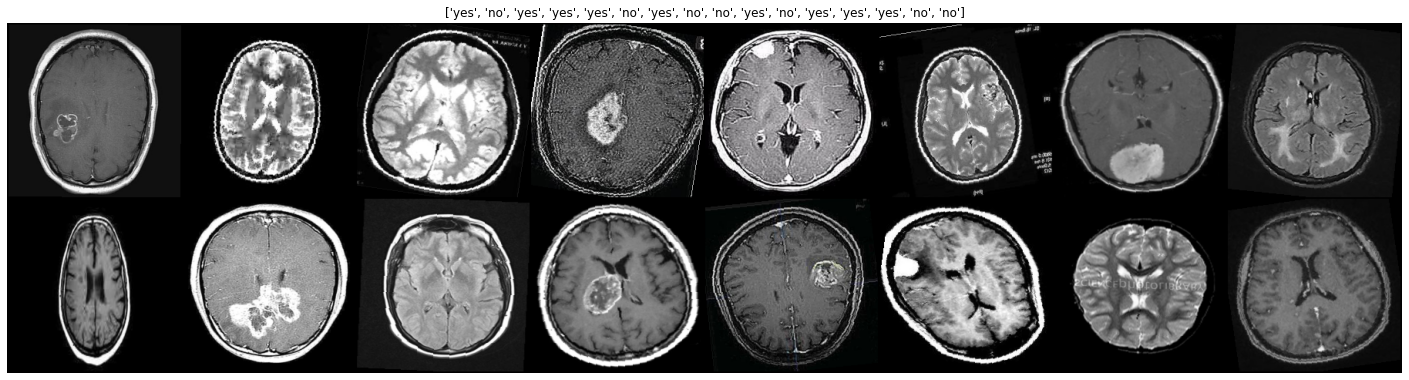

In [119]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(25, 25))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

show_databatch(inputs, classes)

In [120]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        size = inputs.size()[0]
        
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training)

In [121]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders['val'])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders['val']):
        if i % 10 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data).item()

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes['val']
    avg_acc = acc_test / dataset_sizes['val']
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)


In [122]:
vgg19 = models.vgg19(pretrained=True)
print(vgg19.classifier[6].out_features)  


for param in vgg19.features.parameters():
    param.require_grad = False


num_features = vgg19.classifier[6].in_features
features = list(vgg19.classifier.children())[:-1] 
features.extend([nn.Linear(num_features, len(class_names))])
vgg19.classifier = nn.Sequential(*features)
print(vgg19)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1),

In [123]:
if use_gpu:
    vgg19.cuda()
    
criterion = nn.CrossEntropyLoss()
#optimizer_ft = optim.SGD(vgg19.parameters(), lr=0.001, weight_decay=1e-5, momentum=0.9)
optimizer_ft = optim.Adam(vgg19.parameters(), lr=1e-4, weight_decay=1e-5)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [124]:
print("Test before training")
eval_model(vgg19, criterion)

Test before training
Evaluating model
----------
Test batch 50/57
Evaluation completed in 0m 6s
Avg loss (test): 0.0451
Avg acc (test): 0.4922
----------


In [125]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders['train'])
    val_batches = len(dataloaders['val'])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders['train']):
            if i % 10 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            if i >= train_batches:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data).item()
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()

        avg_loss = loss_train / dataset_sizes['train']
        avg_acc = acc_train / dataset_sizes['train']
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders['val']):
            if i % 10 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data).item()

            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes['val']
        avg_acc_val = acc_val / dataset_sizes['val']
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

In [127]:
vgg19 = train_model(vgg19, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/10
----------
Training batch 130/132
Validation batch 50/57
Epoch 0 result: 
Avg loss (train): 0.0211
Avg acc (train): 0.8714
Avg loss (val): 0.0066
Avg acc (val): 0.9767
----------

Epoch 1/10
----------
Training batch 130/132
Validation batch 50/57
Epoch 1 result: 
Avg loss (train): 0.0061
Avg acc (train): 0.9657
Avg loss (val): 0.0030
Avg acc (val): 0.9811
----------

Epoch 2/10
----------
Training batch 130/132
Validation batch 50/57
Epoch 2 result: 
Avg loss (train): 0.0033
Avg acc (train): 0.9848
Avg loss (val): 0.0080
Avg acc (val): 0.9500
----------

Epoch 3/10
----------
Training batch 130/132
Validation batch 50/57
Epoch 3 result: 
Avg loss (train): 0.0034
Avg acc (train): 0.9814
Avg loss (val): 0.0022
Avg acc (val): 0.9867
----------

Epoch 4/10
----------
Training batch 130/132
Validation batch 50/57
Epoch 4 result: 
Avg loss (train): 0.0017
Avg acc (train): 0.9914
Avg loss (val): 0.0042
Avg acc (val): 0.9900
----------

Epoch 5/10
----------
Training batch 130/132


In [128]:
eval_model(vgg19, criterion)

Evaluating model
----------
Test batch 50/57
Evaluation completed in 0m 6s
Avg loss (test): 0.0025
Avg acc (test): 0.9933
----------


Ground truth:


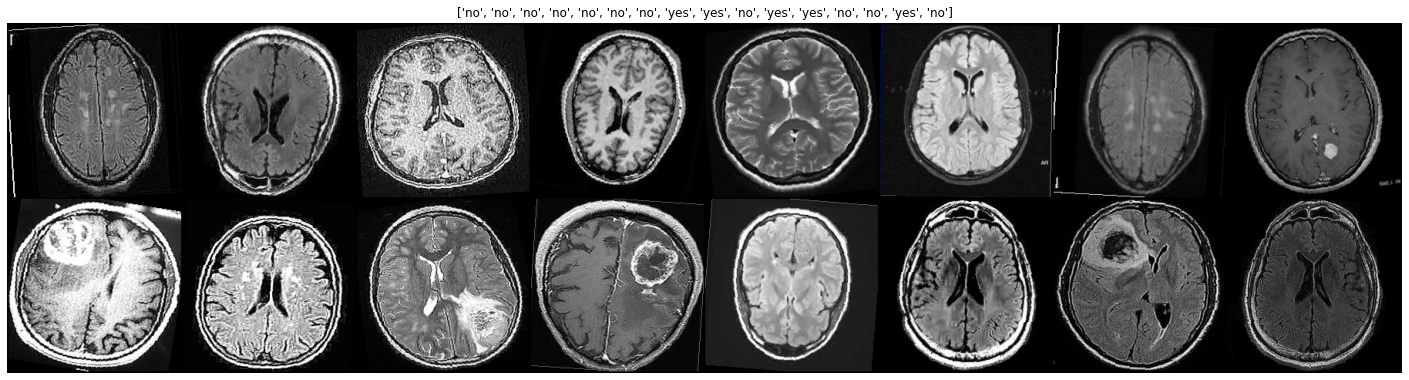

Prediction:


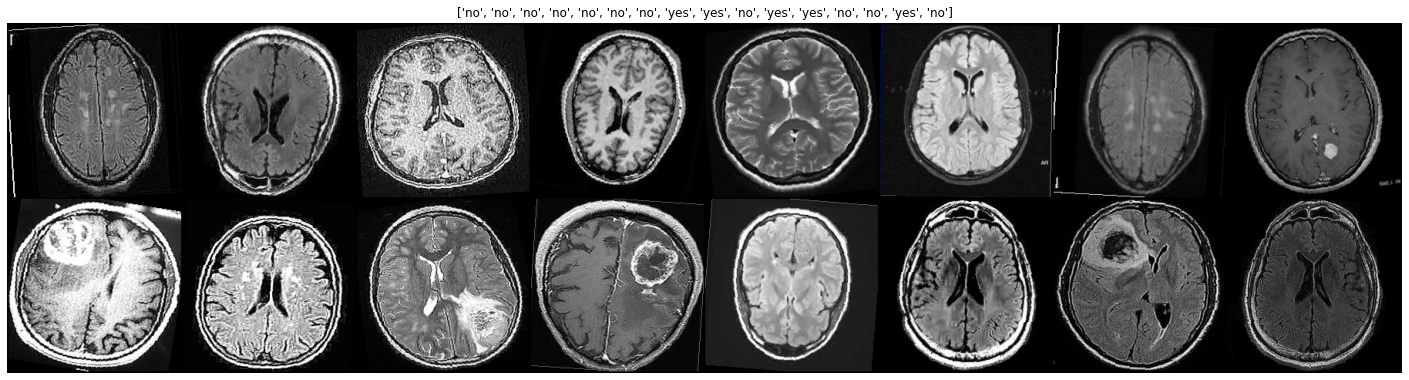

Ground truth:


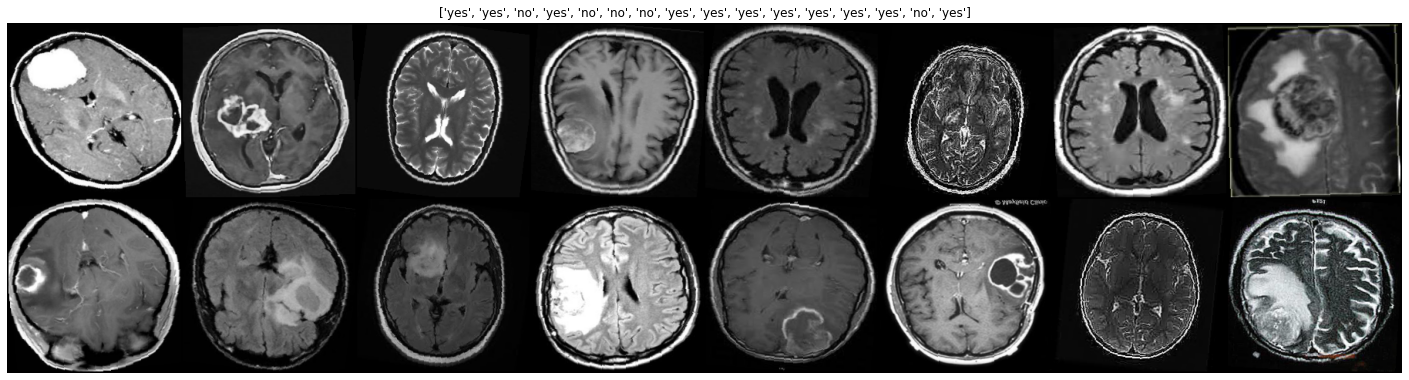

Prediction:


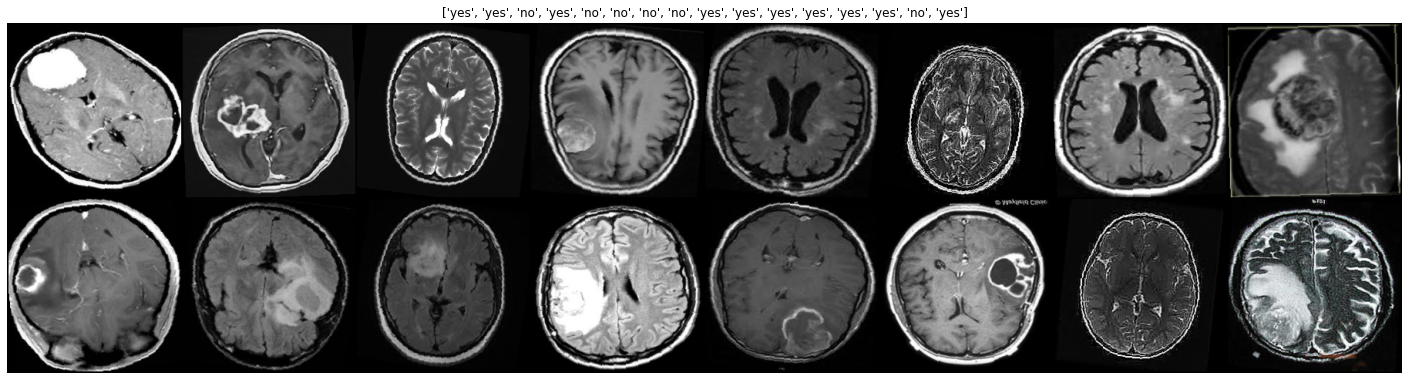

In [129]:
visualize_model(vgg19, num_images=32)